In [ ]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 16.3 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, add, Activation
from tensorflow.keras.layers import BatchNormalization, Dropout, Lambda, multiply
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa

In [ ]:
import os,cv2, random
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.utils import normalize
from tensorflow.keras import layers

# Load data volume and preprocessing

In [ ]:
with open('/content/drive/MyDrive/FYP_colab/Lung_image_volume.npy', 'rb') as f:
    train_images = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/Lung_mask_volume.npy', 'rb') as f:
    train_masks = np.load(f)

In [ ]:
# Normalize image (Always normalize your images when doing deep learning!!!)
# Expand dimension
# image_dataset = np.expand_dims(normalize(train_images, axis=1), 3) # only the images need normalization
# mask_dataset = np.expand_dims(train_masks, 3)/255

image_dataset = np.expand_dims(train_images / np.max(train_images), 3) # only the images need normalization
mask_dataset = np.expand_dims(train_masks, 3)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, 
                                                    test_size = 0.20, random_state = 0)

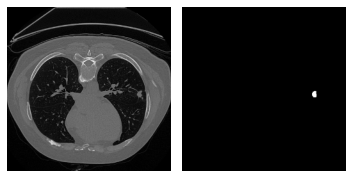

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(5,3))

image_number = random.randint(0,len(train_images))

ax[0].imshow(train_images[image_number,:,:], cmap=plt.cm.gray)
ax[0].axis('off')

ax[1].imshow(train_masks[image_number,:,:], cmap=plt.cm.gray)
ax[1].axis('off')

plt.tight_layout()
#plt.savefig("../images/mask_bbox.png", bbox_inches="tight")
plt.show()

# Loss and Metrics

In [ ]:
def dice_coef(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  dice_coef = 2 * (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)
  return dice_coef

def dice_loss(y_true, y_pred):
  return 1 - dice_coef(y_true, y_pred)

In [ ]:
def jaccard_coef(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  jaccard_coef = (intersection + 1.0)/ (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)  # 1 is probably used to avoid nan for 0/0 
  return jaccard_coef

def jaccard_loss(y_true,y_pred):
  return 1-jaccard_coef(y_true, y_pred)


# Model

## Hyperparameters

In [ ]:
# Define hyperparameters
patch_size = 16
num_patches = (256 // patch_size) ** 2
projection_dim = 784
num_transformer_layer = 12 
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers

## Patch Encoder

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        # print(self.position_embedding(positions).shape)
        # print(self.projection(patch).shape)
        
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Visualization

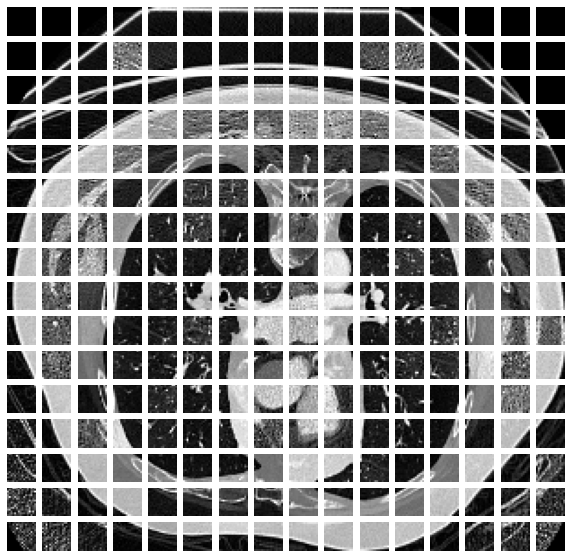

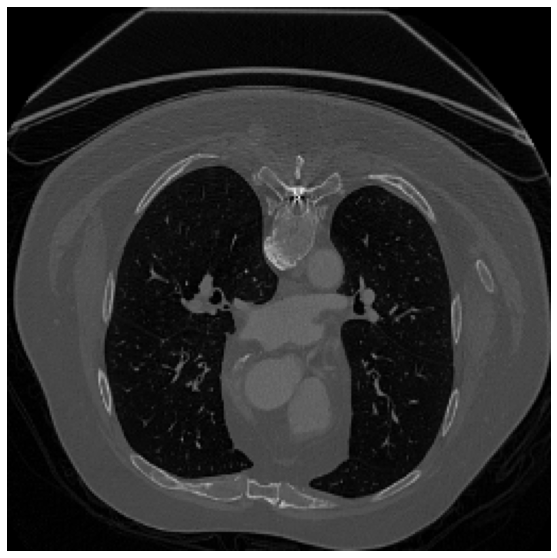

In [ ]:
img = X_train[0,:,:,0]
V_Height, V_Width = img.shape[0], img.shape[1]

patch_list = []
for m in range(V_Height // patch_size):
    for n in range(V_Width // patch_size):
        img_crop = img[m * patch_size :(m+1) * patch_size, n * patch_size :(n+1) * patch_size]
        patch_list.append(img_crop)

plt.figure(figsize=(10,10))
for i in range((V_Height // patch_size) * (V_Width // patch_size)):
    plt.subplot(V_Width // patch_size, V_Width // patch_size, i+1)
    plt.imshow(patch_list[i], cmap='gray')
    plt.axis('off')
    
plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

## Attention Blocks

In [ ]:
def gating_signal(input, out_size, batch_norm=False):
  '''
  return the gating feature map with the same dimension as the up layer feature map
  kind of like the Conv2DTranspose
  '''
  x = Conv2D(out_size, (1,1), padding='same')(input)
  if batch_norm == True:
    x = BatchNormalization()(x)
  x = Activation('relu')(x)
  return x

In [ ]:
def attention_block(x, gating, inter_shape, attNo):
    shape_x = K.int_shape(x) # same usage as numpy.shape
    shape_g = K.int_shape(gating)

    # Getting x to the same shape as the gating signal. 
    theta_x = Conv2D(inter_shape, (2,2), padding='same', strides=(2,2))(x)

    # Getting gating signal to the same number of filter
    phi_g = Conv2D(inter_shape, (1,1), padding='same')(gating)

    concat_xg = add([phi_g, theta_x]) # this is actually add not concatenate.

    act_xg = Activation('relu')(concat_xg)

    psi = Conv2D(1, (1,1), padding='same')(act_xg) 
    psi = BatchNormalization(axis = 3, name='psi'+str(attNo))(psi)
    
    sigmoid_xg = Activation('sigmoid', name='att_weights'+str(attNo))(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)

    upsample_psi = UpSampling2D(size = (shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)

    y = multiply([upsample_psi, x])

    result = Conv2D(shape_x[3], (1,1), padding='same', name='att'+str(attNo))(y)
    result = BatchNormalization()(result)

    return result


In [ ]:
def conv_block(input, filter_size, filter, dropout_rate, batch_norm = True):
    conv = Conv2D(filter, (filter_size, filter_size), padding='same', kernel_initializer='he_normal')(input)
    if batch_norm == True:
        conv = BatchNormalization(axis = 3)(conv)
    conv = Activation('relu')(conv)

    conv = Conv2D(filter, (filter_size, filter_size), padding='same', kernel_initializer='he_normal')(conv)
    if batch_norm == True:
        conv = BatchNormalization(axis = 3)(conv)
    conv = Activation('relu')(conv)

    if dropout_rate > 0:
        conv = Dropout(dropout_rate)(conv)

    return conv

# Neighbour-skip Trans Attention Unet (TAU) 

In [ ]:
def Trans_Attention(H, W, C, patch_size, dropout_rate=0.0, batch_norm=True):
    FILTER_SIZE = 3
    FILTER_NUM = 64
    UP_SAMPLE_SIZE = 2

    inputs = Input(shape=(H,W,C))
    # Augment data.
    # augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # transblock3 = Transformer_Encoder_Block(num_transformer_layer, projection_dim, num_heads, transformer_units)

    # z3 = transblock3(encoded_patches)  # (num of image(batch size), num_patches, K)
    # z6 = transblock3(z3) 
    # z9 = transblock3(z6) 
    # z12 = transblock3(z9) 
    
    for i in range(num_transformer_layer):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1. 
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])
        if i == 2:
            z3 = encoded_patches
        elif i==5:
            z6 = encoded_patches
        elif i==8:
            z9 = encoded_patches
        elif i==11:
            z12 = encoded_patches

    z3 = layers.Reshape((H // patch_size, W // patch_size, 784), input_shape=(256, 784))(z3)
    z6 = layers.Reshape((H // patch_size, W // patch_size, 784), input_shape=(256, 784))(z6)
    z9 = layers.Reshape((H // patch_size, W // patch_size, 784), input_shape=(256, 784))(z9)
    z12 = layers.Reshape((H // patch_size, W // patch_size, 784), input_shape=(256, 784))(z12)

    z3 = add([z3, z6])
    z6 = add([z6, z9])
    z9 = add([z9, z12])

    c12 = Conv2D(16 * FILTER_NUM, (FILTER_SIZE, FILTER_SIZE), padding='same', kernel_initializer='he_normal')(z12)
    c12 = BatchNormalization(axis = 3)(c12)
    c12 = Activation('relu')(c12)
    u12 = UpSampling2D(size=(UP_SAMPLE_SIZE, UP_SAMPLE_SIZE))(c12)

    c9 = Conv2DTranspose(8 * FILTER_NUM, (FILTER_SIZE, FILTER_SIZE), strides=(2,2), activation="relu", padding='same', kernel_initializer='he_normal')(z9)
    g12 = gating_signal(c12, FILTER_NUM*8, batch_norm=False)
    att9 = attention_block(c9, g12, FILTER_NUM*8, attNo = 9)
    concat9 = concatenate([att9, u12])
    c9 = conv_block(concat9, FILTER_SIZE, FILTER_NUM*8, dropout_rate, batch_norm)
    u9 = UpSampling2D(size=(UP_SAMPLE_SIZE, UP_SAMPLE_SIZE))(c9)

    c6 = Conv2DTranspose(8 * FILTER_NUM, (FILTER_SIZE, FILTER_SIZE), strides=(2,2), activation="relu", padding='same', kernel_initializer='he_normal')(z6)
    c6 = Conv2DTranspose(4 * FILTER_NUM, (FILTER_SIZE, FILTER_SIZE), strides=(2,2), activation="relu", padding='same', kernel_initializer='he_normal')(c6)
    g9 = gating_signal(c9, FILTER_NUM*4, batch_norm=False)
    att6 = attention_block(c6, g9, FILTER_NUM*4, attNo = 6)
    concat6 = concatenate([att6, u9])
    c6 = conv_block(concat6, FILTER_SIZE, FILTER_NUM*4, dropout_rate, batch_norm)
    u6 = UpSampling2D(size=(UP_SAMPLE_SIZE, UP_SAMPLE_SIZE))(c6)
    
    c3 = Conv2DTranspose(8 * FILTER_NUM, (FILTER_SIZE, FILTER_SIZE), strides=(2,2), activation="relu", padding='same', kernel_initializer='he_normal')(z3)
    c3 = Conv2DTranspose(4 * FILTER_NUM, (FILTER_SIZE, FILTER_SIZE), strides=(2,2), activation="relu", padding='same', kernel_initializer='he_normal')(c3)
    c3 = Conv2DTranspose(2 * FILTER_NUM, (FILTER_SIZE, FILTER_SIZE), strides=(2,2), activation="relu", padding='same', kernel_initializer='he_normal')(c3)
    g6 = gating_signal(c6, FILTER_NUM*2, batch_norm=False)
    att3 = attention_block(c3, g6, FILTER_NUM*2, attNo = 3)
    concat3 = concatenate([att3, u6])
    c3 = conv_block(concat3, FILTER_SIZE, FILTER_NUM*2, dropout_rate, batch_norm)
    u3 = UpSampling2D(size=(UP_SAMPLE_SIZE, UP_SAMPLE_SIZE))(c3)
    
    c1 = conv_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    g3 = gating_signal(c3, FILTER_NUM, batch_norm=False)
    att1 = attention_block(c1, g3, FILTER_NUM, attNo = 1)
    concat1 = concatenate([att1, u3])
    c1 = conv_block(concat1, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    outputs = Conv2D(1, (1,1), padding='same')(c1)
    outputs = BatchNormalization(axis=3)(outputs)
    outputs = Activation('sigmoid')(outputs)  # Change to softmax for multichannel

    model = Model(inputs = [inputs], outputs = [outputs])
    # model.summary()
    return model


## Load and Train

### Load

In [ ]:
# model takes in 3 parameters H, W, C
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

In [ ]:
NSTAU = Trans_Attention(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, patch_size, dropout_rate=0.0, batch_norm=True)

In [ ]:
NSTAU.summary()

### Train

In [ ]:
NSTAU.compile(optimizer='adam', 
                      loss=[dice_loss],
                      metrics=[dice_coef, jaccard_coef, 'accuracy'])

In [ ]:
NSTAU.optimizer.lr

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>

In [ ]:
# Define callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

checkpoint_path = '/content/checkpoint/NSTAU_lung_TestNotVal_dice_loss_epoch_{epoch:02d}.hdf5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_weights_only=True)

earlystop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

logs = CSVLogger('NSTAU_TestNotVal_dice_logs.csv', 
                 separator=',', append=False)

callbacks = [checkpoint, logs, earlystop]

In [ ]:
import datetime
start1 = datetime.datetime.now()

history_NSTAU = NSTAU.fit(X_train, y_train, batch_size=2, epochs=100, verbose=1, validation_split = 0.2, callbacks=callbacks)

stop1 = datetime.datetime.now()
#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)

### Visualization

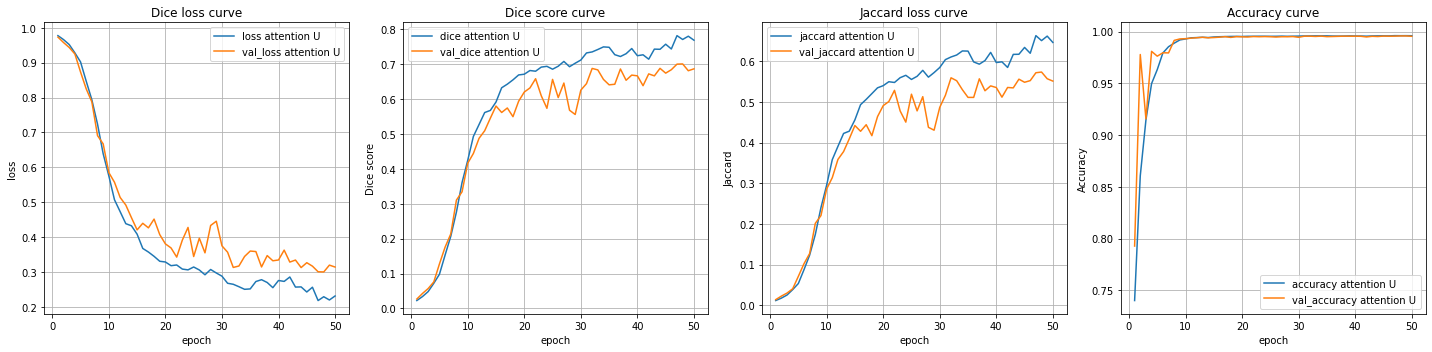

In [ ]:
loss = history_TAU.history['loss'] 
val_loss = history_TAU.history['val_loss']
dice = history_TAU.history['dice_coef'] 
val_dice = history_TAU.history['val_dice_coef'] 
jaccard = history_TAU.history['jaccard_coef'] 
val_jaccard = history_TAU.history['val_jaccard_coef'] 
accu = history_TAU.history['accuracy'] 
val_accu = history_TAU.history['val_accuracy'] 

epoch = range(1, len(loss) + 1)
plt.figure(figsize=(20,5))
plt.subplot(141)
plt.plot(epoch, loss)
plt.plot(epoch, val_loss)

plt.grid()
plt.legend(['loss attention U', 'val_loss attention U'], loc = 'best')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Dice loss curve')

plt.subplot(142)
plt.plot(epoch, dice)
plt.plot(epoch, val_dice)

plt.grid()
plt.legend(['dice attention U', 'val_dice attention U'], loc = 'best')
plt.xlabel('epoch')
plt.ylabel('Dice score')
plt.title('Dice score curve')

plt.subplot(143)
plt.plot(epoch, jaccard)
plt.plot(epoch, val_jaccard)

plt.grid()
plt.legend(['jaccard attention U', 'val_jaccard attention U'], loc = 'best')
plt.xlabel('epoch')
plt.ylabel('Jaccard')
plt.title('Jaccard loss curve')

plt.subplot(144)
plt.plot(epoch, accu)
plt.plot(epoch, val_accu)

plt.grid()
plt.legend(['accuracy attention U', 'val_accuracy attention U'], loc = 'best')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy curve')

plt.tight_layout()
plt.show()

### Evaluation

In [ ]:
TAU.load_weights('/content/drive/MyDrive/FYP_colab/Decathon_Lung_TAU/TAU_lung_TestNotVal_dice_loss_epoch_48.hdf5')

In [ ]:
y_pred = NSTAU.predict(X_test) # running on the positive test set

In [ ]:
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou = intersection / (union + 1e-9)
iou = np.sum(intersection) / np.sum(union)
print("iou: ", iou)


iou:  0.5250140228104383


In [ ]:
precision = np.sum(intersection) / np.sum(y_pred_thresholded)
precision

0.9414807630132558

In [ ]:
recall = np.sum(intersection) / np.sum(y_test)
recall

0.7118161134248162

In [ ]:
y_true_f = y_test.flatten()
y_pred_f = y_pred.flatten()
intersection = np.sum(y_true_f * y_pred_f)
dice_coef = 2 * (intersection + 1e-9) / (np.sum(y_true_f) + np.sum(y_pred_f) + 1e-9)
dice_coef

0.7656602762009083

In [ ]:
corr = np.logical_not(np.logical_xor(y_test, y_pred_thresholded))
accu = int(np.sum(corr)) / (332 * (256 ** 2))
accu

0.9967307584831514

#### Negative dataset

In [ ]:
with open('/content/drive/MyDrive/FYP_colab/Lung_image_volume_negative.npy', 'rb') as f:
    negative_images = np.load(f)
with open('/content/drive/MyDrive/FYP_colab/Lung_mask_volume_negative.npy', 'rb') as f:
    negative_masks = np.load(f)

In [ ]:
X_test_negative = np.expand_dims(negative_images / np.max(train_images), 3) # only the images need normalization
y_test_negative = np.expand_dims(negative_masks, 3)

In [ ]:
y_test_negative.shape

(150, 256, 256, 1)

In [ ]:
negative_pred = TAU.predict(X_test_negative)

In [ ]:
negative_pred_thresholded = negative_pred > 0.5
corr = np.logical_not(np.logical_xor(y_test_negative, negative_pred_thresholded))
accu = int(np.sum(corr)) / (150 * (256 ** 2))
accu

0.997313232421875

#### Mixed dataset

In [ ]:
mixedset_images = np.concatenate((X_test_negative, X_test), axis=0)
mixedset_masks = np.concatenate((y_test_negative, y_test), axis=0)

#### Obtain SML dataset

In [ ]:
ratios = []
for index in range(y_test.shape[0]):
    image = y_test[index]
    ratio = np.sum(image) / 256**2
    ratios.append(ratio)

ratios = np.array(ratios)
sort_index = np.argsort(ratios) # s -> L
sorted = np.sort(ratios)

X_test_S = X_test[sort_index[:110]]
y_test_S = y_test[sort_index[:110]]

X_test_M = X_test[sort_index[111:220]]
y_test_M = y_test[sort_index[111:220]]

X_test_L = X_test[sort_index[221:]]
y_test_L = y_test[sort_index[221:]]
#     if ratio < 1e-3:
#         y_test_S = np.concatenate((y_test_S, y_test[index].reshape((1,256,256,1))), axis=0)
#         X_test_S = np.concatenate((X_test_S, y_test[index].reshape((1,256,256,1))), axis=0)

In [ ]:
np.save('Lung_L_images.npy', X_test_L)

In [ ]:
y_pred_S = TAU.predict(X_test_S) # running on the positive test set

In [ ]:
y_pred_M = TAU.predict(X_test_M) # running on the positive test set

In [ ]:
y_pred_L = TAU.predict(X_test_L) # running on the positive test set

In [ ]:
y_true_Sf = y_test_S.flatten()
y_pred_Sf = y_pred_S.flatten()
intersection = np.sum(y_true_Sf * y_pred_Sf)
dice_coef_S = 2 * (intersection + 1e-9) / (np.sum(y_true_Sf) + np.sum(y_pred_Sf) + 1e-9)
dice_coef_S

0.40370955888860377

In [ ]:
y_true_Mf = y_test_M.flatten()
y_pred_Mf = y_pred_M.flatten()
intersection = np.sum(y_true_Mf * y_pred_Mf)
dice_coef_M = 2 * (intersection + 1e-9) / (np.sum(y_true_Mf) + np.sum(y_pred_Mf) + 1e-9)
dice_coef_M

0.7042091033278355

In [ ]:
y_true_Lf = y_test_L.flatten()
y_pred_Lf = y_pred_L.flatten()
intersection = np.sum(y_true_Lf * y_pred_Lf)
dice_coef_L = 2 * (intersection + 1e-9) / (np.sum(y_true_Lf) + np.sum(y_pred_Lf) + 1e-9)
dice_coef_L

0.7963649573893157